In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

# Using the Adjoint Gradient Result Type on Amazon Braket

In this tutorial we'll introduce the `AdjointGradient` result type, discuss what a gradient is and how to compute one on a quantum circuit, explain how they can be used to accelerate your workflows, and show an example of gradients in action on a hybrid quantum algorithm.

<div class="alert alert-block alert-info">
<b>Note:</b> This notebook requires amazon-braket-sdk-python>=1.35.0
</div>

## Table of Contents

- [Background: What is a gradient?]()
- [Why compute gradients?]()
- [Computing gradients of parameters in a quantum circuit]()
  - [Finite differences]()
  - [Parameter shift]()
  - [Adjoint gradient]()
- [The `AdjointGradient` result type]()
- [Accelerating QAOA with `AdjointGradient`]()

## Background: What is a gradient?

A [gradient](https://en.wikipedia.org/wiki/Gradient) refers to a vector derivative of a scalar-valued function of multiple variables. If we have a function $f(x)$, which depends only on $x$ and maps $x \to \mathbb{R}$ (maps $x$ to a single real number), then $f$'s gradient is just its derivative with respect to $x$: $\frac{df}{dx}$. The gradient is denoted $\nabla$, so that $\nabla f(x) = \frac{df}{dx}$. However, if $f$ is a function of multiple variables, mapping $\mathbb{R}^n \to \mathbb{R}$, we must take partial derivatives with respect to each variable. For example:

$$ \nabla f(x, y, z) = \left[\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}, \frac{\partial f}{\partial z}\right] $$

The gradient of $f$ is itself a function and can be evaluated on specific values of $x$, $y$, and $z$. In general, for a function $f$ of $n$ independent real variables, $\nabla f$ is a length $n$ vector.

## Why compute gradients?

Gradients are of interest to us because many quantum algorithms -- hybrid classical-quantum algorithms such as the quantum approximate optimization algorithm (QAOA) or the variational quantum eigensolver (VQE) especially -- can be formulated as a problem of optimizing parameters (i.e. variables) in a quantum circuit with respect to some cost function, for example an expectation value of a Hamiltonian. To efficiently perform this optimization it's common to use a gradient based optimization method, such as gradient descent (stochastic or not). An efficient means of computing gradients allows us to arrive at a good solution to the optimization problem in fewer circuit evaluations, and thus less cost.

## Computing gradients of parameters in a quantum circuit

Let's make this a little more concrete. Suppose we have a quantum circuit which depends on a set of parameters $\vec{p}$. We can compactly represent this circuit as $U(\vec{p})$, where $U$ is the unitary that represents the action of all the gates in the circuit. Further suppose that after running this circuit, we will compute the expectation value of some operator $\hat{O}$ (for example, a Hamiltonian) and use the result to determine how good our choice of parameters $\vec{p}$ was. This situation arises often when running hybrid algorithms or quantum machine learning workflows. 

<div class="alert alert-block alert-info">
<b>Note</b> Although, for the sake of simplicity, we will only discuss measuring expectation values to generate the function to differentiate, one can equally well compute variances or any other scalar valued function.
</div>

We can express this whole procedure as:

$$ f(\vec{p}) = \left\langle \psi \right| \hat{O} \left| \psi \right\rangle = \left\langle 0 U^\dagger(\vec{p}) \right| \hat{O} \left| U(\vec{p}) 0 \right\rangle $$

$f(\vec{p})$ is a scalar valued function and we can compute its gradient -- all its partial derivatives with respect to the parameters $\vec{p}$ -- in order to optimize those parameters. There are a variety of methods available to compute these derivatives, three of which will be discussed below. Of the three, the adjoint differentiation method is the fastest and most frugal in circuit executions and should be preferred when available, that is, when running on a state vector simulator in exact (`shots=0`) mode. We'll introduce these other two common approaches to better understand the benefit of using the adjoint differentiation method.

### Finite differences

The [finite difference method](https://en.wikipedia.org/wiki/Finite_difference) is a common technique used to approximate derivatives. Suppose we have a function $f(\vec{p})$ and we want to compute the $i$-th partial derivative of $f$, $\frac{\partial f}{\partial p_i}$. We can do so by approximating:

$$ \frac{\partial f}{\partial p_i} \approx \frac{f(p_1, p_2, ..., p_i + h, ..., p_n) - f(p_1, p_2, ..., p_i, ..., p_n)}{h} $$

Where $h$ is some small real number. This formula might seem familiar from introductory calculus.  The smaller $h$ is the better approximated the derivative is. By keeping all other parameters fixed, we can approximate the partial derivative with respect to $p_i$, but as we can see, computing *each* partial derivative would require *two* full circuit executions (one to compute each value of $f$). Thus, the total number of circuit executions needed to compute the gradient of $f$ for *one* set of values $\vec{p}$ would be $2n$, if the length of $p$ is $n$.

For a quantum circuit there can be additional problems. On a real quantum device, we can't compute the exact expectation value (or variance) of a circuit. We can only run many shots, each of which is a full circuit execution, and approximate the expectation value from the measurement statistics that result. This means that for very small $h$, it may be very difficult to approximate the gradient accurately.

### Parameter shift rules

Let's return to our original formula for the gradient of $f$:

$$ \nabla f(\vec{p}) = \left(\frac{\partial f}{\partial p_1}, \ldots , \frac{\partial f}{\partial p_n}\right) $$

and examine one of the vector elements a little more closely:

$$ \frac{\partial f}{\partial p_i} = \frac{\partial}{\partial p_i} \left\langle 0 U^\dagger(\vec{p}) \right| \hat{O} \left| U(\vec{p}) 0 \right\rangle = \frac{\partial}{\partial p_i} \left\langle 0 \right| U^\dagger(\vec{p}) \hat{O} U(\vec{p}) \left| 0 \right\rangle $$

We can pull the derivative operator inside the expectation value so that:

$$ \frac{\partial f}{\partial p_i} = \left\langle 0 \left|\frac{\partial}{\partial p_i} \left( U^\dagger(\vec{p}) \hat{O} U(\vec{p})\right) \right| 0 \right\rangle $$

We'll assume that each gate depends on at most one parameter, and each parameter appears in only one gate. What if we have repeated parameters? We can write down a mapping of each repeated parameter to a unique copy and sum the derivatives of those copies at the end using the [product rule](https://en.wikipedia.org/wiki/Product_rule). But for now, for simplicity we will assume that each parameter appears only once and each gate has at most one parameter. Further we'll state that gate $i$ is associated with the $i$-th parameter (every gate has a parameter). If non-parametrized gates are present, we can contract them into parametrized gates to achieve this, or assign them constant parameters (remember, the derivative of a constant is always 0).

We can write that the overall circuit unitary $U$ is a product of individual gates:

$$ U(\vec{p}) = \otimes_{i=1}^N U_{i}(p_i) $$

if there are $N$ gates in the circuit.

Then, using the product rule, we can write:

$$ \frac{\partial f}{\partial p_i} = \left\langle 0 \left| \otimes_{j=1}^{i-1} U^\dagger_j \otimes \frac{\partial U^\dagger_i(p_i)}{\partial p_i} \otimes_{j=i+1}^{n} U^\dagger_j \hat{O} U(\vec{p}) + U^\dagger(\vec{p}) \hat{O}\otimes_{j=i+1}^{n} U_j \otimes \frac{\partial U_i(p_i)}{\partial p_i}\otimes_{j=1}^{i-1} U_j \right| 0 \right\rangle $$

We can absorb the non-differentiated products so that:

$$ \frac{\partial f}{\partial p_i} = \left\langle \phi \left| \frac{\partial U^\dagger_i(p_i)}{\partial p_i} \hat{\mathcal{O}}U_i(p_i) + U^\dagger_i(p_i)\hat{\mathcal{O}}\frac{\partial U_i(p_i)}{\partial p_i}\right| \phi \right\rangle $$

where

$$ \phi = \otimes_{j=1}^{i-1} U_j \left| 0 \right\rangle $$

and 

$$ \hat{\mathcal{O}} = \otimes_{j=i+1}^{n} U^\dagger_j  \hat{O} \otimes_{j=i+1}^{n} U_j $$.

Now we can see that

$$ \frac{\partial U^\dagger_i(p_i)}{\partial p_i} \hat{\mathcal{O}}U_i(p_i) + U^\dagger_i(p_i)\hat{\mathcal{O}}\frac{\partial U_i(p_i)}{\partial p_i} = \frac{\partial}{\partial p_i} \left( U_i^\dagger(p_i) \hat{\mathcal{O}} U_i(p_i)\right) $$

so, in sum:

$$ \frac{\partial f}{\partial p_i} = \left\langle \phi \left|\frac{\partial}{\partial p_i} \left( U_i^\dagger(p_i) \hat{\mathcal{O}} U_i(p_i)\right)\right| \phi \right\rangle $$

and in many cases (but not all!) we can define a *shift* $s$ such that:

$$ \frac{\partial}{\partial p_i} \left( U_i^\dagger(p_i) \hat{\mathcal{O}} U_i(p_i)\right) = U_i^\dagger(p_i + s) \hat{\mathcal{O}} U_i(p_i + s) - U_i^\dagger(p_i - s) \hat{\mathcal{O}} U_i(p_i - s) $$

Thus the name "parameter shift". What makes this different from the finite differences method is that $s$ is not necessarily small. Detailed guides to choosing shifts and identifying which gates support the method can be found in Refs. [1](https://arxiv.org/abs/1803.00745) and [2](https://arxiv.org/abs/1811.11184). If a gate does *not* support a parameter shift rule, we can always fall back to the finite difference method.

We can see that the parameter shift method *also* requires two circuit executions to compute the partial derivative of each parametrized gate. The advantage over finite difference is in numerical accuracy. Parameter shift can be used both when `shots=0` or when `shots>0`. Since the introduction of the method, many extensions and generalizations have been published, including Refs. [3](https://arxiv.org/abs/2107.12390), [4](https://arxiv.org/abs/2005.10299), and many more. 

### Adjoint differentiation

The two methods we've examined so far, finite differences and parameter shift, both require two full circuit executions per parameter to compute the gradient. This can become very expensive, in both time and charges, for deep circuits and/or circuits with many parameters. Is there a way to compute gradients in a more "execution-frugal" way? For `shots=0`, the answer is yes. First introduced in Ref. [5](https://arxiv.org/abs/2009.02823), the adjoint differentiation method allows us to compute all partial derivatives in "1+1" circuit executions. How does it work? Recall that:

$$ \frac{\partial f}{\partial p_i} = \left\langle 0 \left| \otimes_{j=1}^{i-1} U^\dagger_j \otimes \frac{\partial U^\dagger_i(p_i)}{\partial p_i} \otimes_{j=i+1}^{n} U^\dagger_j \hat{O} U(\vec{p}) + U^\dagger(\vec{p}) \hat{O}\otimes_{j=i+1}^{n} U_j \otimes \frac{\partial U_i(p_i)}{\partial p_i}\otimes_{j=1}^{i-1} U_j \right| 0 \right\rangle $$

In the adjoint method, we take a different approach to computing this derivative. We realize that:

$$ \left( \left \langle 0 \left| \otimes_{j=1}^{i-1} U^\dagger_j \otimes \frac{\partial U^\dagger_i(p_i)}{\partial p_i} \otimes_{j=i+1}^{n} U^\dagger_j \hat{O} U(\vec{p}) \right| 0 \right\rangle \right)^\dagger = \left \langle 0 \left| U^\dagger(\vec{p}) \hat{O}\otimes_{j=i+1}^{n} U_j \otimes \frac{\partial U_i(p_i)}{\partial p_i}\otimes_{j=1}^{i-1} U_j \right| 0 \right\rangle$$

and thus, because all the gates are unitaries and the operator $\hat{O}$ is Hermitian,

$$ \frac{\partial f}{\partial p_i} = 2\Re \left\langle 0 \left| U^\dagger(\vec{p}) \hat{O}\otimes_{j=i+1}^{n} U_j \otimes \frac{\partial U_i(p_i)}{\partial p_i}\otimes_{j=1}^{i-1} U_j \right| 0 \right\rangle $$

where $\Re$ denotes the real part. Now we can absorb some factors so that:

$$ \frac{\partial f}{\partial p_i} = 2\Re \left\langle b_i \left| \frac{\partial U_i(p_i)}{\partial p_i} \right| k_i \right\rangle $$

where

$$ \left\langle b_i \right| = \left\langle 0 \right| U^\dagger(\vec{p}) \hat{O}\otimes_{j=i+1}^{n} U_j(p_j) $$

and

$$ \left | k_i \right\rangle = \otimes_{j=1}^{i-1} U_j(p_j) \left| 0 \right\rangle $$

The basis of the adjoint method is realizing that we can iteratively compute each partial derivative by "back stepping" through the circuit after having applied all its gates once. This is very similar to classical back propagation, if you're familiar with that technique from classical machine learning. We first apply all gates to compute $ \left| k_n \right\rangle = \otimes_{j=1}^{n} U_j \left| 0 \right\rangle $, copy the state and apply $\hat{O}$ to acquire:

$$ \left\langle b_n \right| = \left\langle 0 \right| U^\dagger(\vec{p}) \hat{O} $$

then compute $\frac{\partial f}{\partial p_n}$:

$$ \frac{\partial f}{\partial p_n} = \left\langle b_n \left|\frac{\partial U_n(p_n)}{\partial p_n}\right| k_n \right\rangle $$

In a moment we'll address how to find $\frac{\partial U_n(p_n)}{\partial p_n}$. Once we've computed the first partial derivative, we update $\left\langle b_n\right|$ and $ \left| k_n \right\rangle$ to generate:

$$ \left\langle b_{n-1} \right| = \left\langle b_n \right| U_n(p_n) $$
$$ \left | k_{n-1} \right\rangle =  U^\dagger_{n-1} \left| k_n \right\rangle $$

By iteratively updating these two states, we can compute all partial derivatives with only one circuit execution plus one "back step" execution, significantly less than what is required by finite differences or parameter shift. The cost is that there is additional memory overhead, as we have to store an additional state vector and compute a third in the expectation value $\left\langle b_i \left|\frac{\partial U_i(p_i)}{\partial p_i}\right| k_i \right\rangle$.

How do we compute the derivative $\frac{\partial U_i(p_i)}{\partial p_i}$? In many cases, if $U_i(p_i)$ is continually differentiable with respect to $p_i$, we can simply take a matrix derivative. In particular, many parametrizable gates can be written as exponentials of Paulis, so that:

$$ \frac{\partial U_i(p_i)}{\partial p_i} = \frac{\partial}{\partial p_i}\exp\left\{ i c p_i \hat{P}\right\} = i c \hat{P} \exp\left\{ i c p_i \hat{P}\right\} $$

where $c$ is some constant, $\hat{P}$ is some Pauli gate, and $i$ is the imaginary number $\sqrt{-1}$. This is easily generalizable to exponents of sums of Paulis through the [chain rule](https://en.wikipedia.org/wiki/Chain_rule). In cases where $U(p_i)$ is *not* continuously differentiable, the derivative can be computed numerically, e.g. through finite differences as discussed above.

<div class="alert alert-block alert-info">
<b>Note</b> Because it is formulated <b>only</b> for exact computations, the adjoint method can only be used on simulators, such as SV1, when running with <code>shots=0</code>.
</div>

The adjoint differentiation method is available through the `AdjointGradient` result type on Amazon Braket, which we'll introduce in the next section. With this result type, all gradients are computed using the adjoint differentiation method.

## The `AdjointGradient` Result Type

Amazon Braket now supports a result type, `AdjointGradient`, which allows you to conveniently compute gradients of free parameters with respect to the expectation value of some observable on your circuits.

<div class="alert alert-block alert-info">
<b>Note</b> Currently, the <code>AdjointGradient</code> result type is <b>only</b> supported on SV1 when running in <code>shots=0</code> mode. All gradients are computed using the adjoint differentiation method.
</div>

Let's see an example of this result type in action:

In [16]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import random
# magic line for producing visualizations in notebook
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable, FreeParameter
from braket.aws import AwsDevice
from braket.devices import Devices

In [17]:
device = AwsDevice(Devices.Amazon.SV1)

We can prepare a simple parametrized circuit and compute its gradient with respect to some observable. Note that you supply the observable to the `AdjointGradient` result type. Supported observables are:
  - Any of `Observable.Z()`, `Observable.X()`, `Observable.Y()`, `Observable.H()`, or `Observable.I()`
  - A `TensorProduct`
  - A `Hermitian`
  - A `Sum`
  
You can also supply the list of parameters to compute partial derivatives with respect to. If a parameter is present in the circuit, but not in the `parameters` argument to `adjoint_gradient`, its corresponding partial derivative will not be computed. If the list of `parameters` is empty, the gradient will be computed with respect to all free parameters present in the circuit.

In [18]:
theta = FreeParameter('theta')
gamma = FreeParameter('gamma')
circuit = Circuit().h(0).cnot(0, 1).rx(0, theta).rx(1, theta).xx(0, 1, gamma)
# add the adjoint gradient result type
#circuit.adjoint_gradient(observable = Observable.Z() @ Observable.Z(), target = [0, 1], parameters=['theta', gamma])
circuit.adjoint_gradient(observable = Observable.Z() @ Observable.Z(), target = [0, 1], parameters=[])

Circuit('instructions': [Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Rx('angle': theta, 'qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Rx('angle': theta, 'qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': XX('angle': gamma, 'qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)], 'result_types': [AdjointGradient(observable=TensorProduct(Z('qubit_count': 1), Z('qubit_count': 1)), target=QubitSet([Qubit(0), Qubit(1)]), parameters=[])])

Now we can compute the gradient of the circuit with respect to our two free parameters for a given set of parameter values, which we supply to `device.run` with the `inputs` argument:

In [19]:
result_1 = device.run(circuit, shots=0, inputs = {'theta': 0.1, 'gamma': 0.05}).result()
result_2 = device.run(circuit, shots=0, inputs = {'theta': 0.2, 'gamma': 0.1}).result()

print(f"Gradient when theta = 0.1, gamma = 0.05: {result_1.values[0]}")
print(f"Gradient when theta = 0.2, gamma = 0.1: {result_2.values[0]}")

Gradient when theta = 0.1, gamma = 0.05: {'expectation': 0.9800665778412416, 'gradient': {'gamma': 6.938893903907228e-18, 'theta': -0.39733866159012254}}
Gradient when theta = 0.2, gamma = 0.1: {'expectation': 0.9210609940028854, 'gradient': {'gamma': -4.336808689942018e-19, 'theta': -0.7788366846173013}}


We can immediately see that although `theta` appears twice in the circuit (in two `Rx` gates), it only appears once in the result. `AdjointGradient` computes gradients **per parameter**, and **not** per-gate. We can also see that if `parameters` is empty, derivatives with respect to all free parameters will be computed. This is useful in cases when your circuit has a large number of free parameters.

In [20]:
circuit = Circuit().h(0).cnot(0, 1).rx(0, theta).rx(1, theta).xx(0, 1, gamma)
# add the gradient result type
circuit.adjoint_gradient(observable = Observable.Z() @ Observable.Z(), target = [0, 1], parameters=[])
result_all = device.run(circuit, shots=0, inputs = {'theta': 0.2, 'gamma': 0.1}).result()
print(f"Gradient when theta = 0.2, gamma = 0.1: {result_all.values[0]}")

Gradient when theta = 0.2, gamma = 0.1: {'expectation': 0.9210609940028854, 'gradient': {'gamma': -4.336808689942018e-19, 'theta': -0.7788366846173013}}


## Accelerating QAOA with `AdjointGradient`

Now we can see how using the `AdjointGradient` result type can improve performance for a hybrid algorithm such as QAOA. For an introduction to QAOA, see [its example notebook](../hybrid_quantum_algorithms/QAOA/QAOA_braket.ipynb). We'll modify the `train` function to use `AdjointGradient` and determine a Jacobian, and compare this approach with the Jacobian-free method used in the QAOA notebook. Much of the code here is further explained in that notebook, so we strongly suggest you review it before proceeding. We'll run the entire QAOA workflow in `shots=0` mode so that we can compare with `AdjointGradient`, which means we can directly compute the cost (energy). First, we set up the problem and import the circuit generator and training functions:

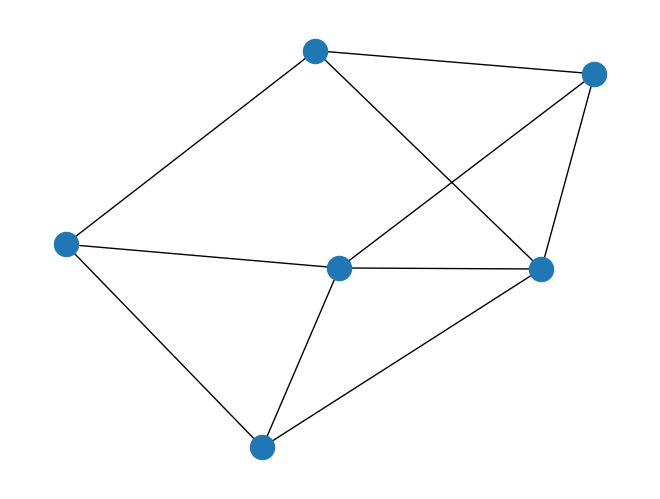

In [21]:
# setup Erdos Renyi graph
n = 6  # number of nodes/vertices
m = 10  # number of edges
seed = 2

# define graph object
G = nx.gnm_random_graph(n, m, seed=seed)
# positions for all nodes
pos = nx.spring_layout(G)

# choose random weights
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.uniform(0, 1)

# draw graph
nx.draw(G, pos)
plt.show()

# set Ising matrix 
Jfull = nx.adjacency_matrix(G).todense()
Jfull = np.array(Jfull)

# get off-diagonal upper triangular matrix
J = np.triu(Jfull, k=1).astype(np.float64)

In [22]:
from utils_qaoa import circuit, train, train_adjoint
# auto reload external files, so that we can edit the external .py file and immediately see the changes here
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now we define hyperparameters. We'll use an optimization method that can benefit from information about the Jacobian, in this case `'BFGS'`, when running with the `AdjointGradient` result type. The same `'BFGS'` optimizer will be used for the gradient free case as a comparison. See the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) for more information about possible optimization methods.

In [23]:
##################################################################################
# set up hyperparameters
##################################################################################

# User-defined hypers
DEPTH = 2  # circuit depth for QAOA
OPT_METHOD = {'adjoint': 'BFGS', 'gradient-free': 'BFGS'}

# set up the problem
n_qubits = J.shape[0]

# initialize reference solution (simple guess)
energy_init = 0.0

##################################################################################
# run QAOA optimization on graph 
##################################################################################

print('Circuit depth hyperparameter:', DEPTH)
print('Problem size:', n_qubits)

# set options for classical optimization
options = {'disp': True, 'maxiter': 3}
verbose = True

np.random.seed(2)
p = DEPTH
# randomly initialize variational parameters within appropriate bounds
gamma_initial = np.random.uniform(0, 2 * np.pi, p).tolist()
beta_initial = np.random.uniform(0, np.pi, p).tolist()
params0 = np.array(gamma_initial + beta_initial)

Circuit depth hyperparameter: 2
Problem size: 6


We're now ready to run the optimization. We'll set up separate cost trackers for each run to compare not only running time, but also billing incurred. First, using the adjoint differentiation method:

In [24]:
adjoint_costs = Tracker().start()
#set up trackers to keep track of results
adjoint_tracker = {
    'count': 1,                           # Elapsed optimization steps
    'optimal_energy': energy_init,        # Global optimal energy
    'opt_energies': [],                   # Optimal energy at each step
    'global_energies': [],                # Global optimal energy at each step
    'costs': [],                          # Cost (energy) at each step
    'res': None,                          # Quantum result object
    'params': []                          # Track parameters
}

# kick off training for adjoint
start = time.time()
result_energy, result_angle, adjoint_tracker = train_adjoint(
    device = device, options=options, p=DEPTH, ising=J, n_qubits=n_qubits,
    opt_method=OPT_METHOD['adjoint'], tracker=adjoint_tracker, params0=params0, verbose=verbose)
end = time.time()

# print execution time
print('Code execution time using adjoint differentiation [sec]:', end - start)

# print optimized results
print('Optimal energy using adjoint differentiation:', adjoint_tracker['optimal_energy'])

Starting the training.
OPTIMIZATION for circuit depth p=2
Initial energy:  0.26097400359407097
Calling the quantum circuit. Cycle: 2
Energy expectation value (cost): 0.26097400359407075
Calling the quantum circuit. Cycle: 3
Energy expectation value (cost): -0.8166638770181708
Calling the quantum circuit. Cycle: 4
Energy expectation value (cost): -0.7763862854880954
Calling the quantum circuit. Cycle: 5
Energy expectation value (cost): 0.31258094995827657
Calling the quantum circuit. Cycle: 6
Energy expectation value (cost): -0.32499066384560926
Calling the quantum circuit. Cycle: 7
Energy expectation value (cost): -0.8416306957717348
Calling the quantum circuit. Cycle: 8
Energy expectation value (cost): -1.0085990046902733
Calling the quantum circuit. Cycle: 9
Energy expectation value (cost): -0.28725978101198607
Calling the quantum circuit. Cycle: 10
Energy expectation value (cost): -1.2216610700669248
         Current function value: -1.221661
         Iterations: 3
         Function

Let's also examine the costs incurred by running QAOA with the `AdjointGradient` result type and a gradient-aware optimization method:

In [25]:
print("Adjoint Gradient Aware Quantum Task Summary")
print(adjoint_costs.quantum_tasks_statistics())
print(f"Estimated cost to run this example: {adjoint_costs.simulator_tasks_cost():.3f} USD")

Adjoint Gradient Aware Quantum Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 10}, 'execution_duration': datetime.timedelta(microseconds=143000), 'billed_execution_duration': datetime.timedelta(seconds=30)}}
Estimated cost to run this example: 0.038 USD


Finally, we'll run without using the adjoint differentiation method to compute the gradient and compare the running time and costs:

In [26]:
no_adjoint_costs = Tracker().start()
energy_init = 0.0
tracker = {
    'count': 1,                           # Elapsed optimization steps
    'optimal_energy': energy_init,        # Global optimal energy
    'opt_energies': [],                   # Optimal energy at each step
    'global_energies': [],                # Global optimal energy at each step
    'costs': [],                          # Cost (energy) at each step
    'res': None,                          # Quantum result object
    'params': []                          # Track parameters
}

# kick off training for gradient-free
start = time.time()
result_energy, result_angle, tracker = train(
    device = device, options=options, p=DEPTH, ising=J, n_qubits=n_qubits, 
    opt_method=OPT_METHOD['gradient-free'], tracker=tracker, params0=params0, verbose=verbose)
end = time.time()

# print execution time
print('Code execution time without adjoint differentiation [sec]:', end - start)

# print optimized results
print('Optimal energy:', tracker['optimal_energy'])

Starting the training.
OPTIMIZATION for circuit depth p=2
Initial energy:  0.2609740035940707
Calling the quantum circuit. Cycle: 2
Energy expectation value (cost): 0.26097400359407075
Calling the quantum circuit. Cycle: 3
Energy expectation value (cost): 0.26097402262135894
Calling the quantum circuit. Cycle: 4
Energy expectation value (cost): 0.26097404039095057
Calling the quantum circuit. Cycle: 5
Energy expectation value (cost): 0.2609740302412292
Calling the quantum circuit. Cycle: 6
Energy expectation value (cost): 0.26097401070361437
Calling the quantum circuit. Cycle: 7
Energy expectation value (cost): -0.8166639561339399
Calling the quantum circuit. Cycle: 8
Energy expectation value (cost): -0.8166640051368146
Calling the quantum circuit. Cycle: 9
Energy expectation value (cost): -0.8166639893635902
Calling the quantum circuit. Cycle: 10
Energy expectation value (cost): -0.8166639792008459
Calling the quantum circuit. Cycle: 11
Energy expectation value (cost): -0.816664011190

We can examine the costs incurred by running QAOA without the `AdjointGradient` result type, using a finite-differences based optimization method:

In [27]:
print("Gradient-Unaware Quantum Task Summary")
print(no_adjoint_costs.quantum_tasks_statistics())
print(f"Estimated cost to run this example: {no_adjoint_costs.simulator_tasks_cost():.3f} USD")

Gradient-Unaware Quantum Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 46}, 'execution_duration': datetime.timedelta(microseconds=768000), 'billed_execution_duration': datetime.timedelta(seconds=138)}}
Estimated cost to run this example: 0.172 USD


## References

[1] Mitarai K., Negoro M., et al., "Quantum Circuit Learning", Physical Review A 98: 032309 (2018)

[2] Schuld M., Bergholm V., et al., "Evaluating analytic gradients on quantum hardware", Physical Review A 99: 032331 (2019)

[3] Weirechs D., Izaac J, et al., "General parameter-shift rules for quantum gradients", Quantum 6: 677 (2022)

[4] Banchi L., Crooks G., "Measuring Analytic Gradients of General Quantum Evolution with the Stochastic Parameter Shift Rule", Quantum 5: 386 (2021)

[5] Jones T., Gacon J., "Efficient calculation of gradients in classical simulations of variational quantum algorithms", arXiv:2009.02823

In [28]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Quantum Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 94}, 'execution_duration': datetime.timedelta(seconds=2, microseconds=123000), 'billed_execution_duration': datetime.timedelta(seconds=282)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.352 USD
